# Business Problematic

 **Prediction of Rossman sales in the next six weeks**

# Reading Data

In [ ]:
# import relevant libraries
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# loading the 'train' dataset1 of 'Daily sales of each shop and other daily attributes'
# Imane's path
train = pd.read_csv("/content/drive/MyDrive/Redi2021/Copy of Copy of rossman_train.csv")
# # # # # loading the 'store' dataset2 of 'Attributes of each store (competitors, promos etc.)'
store = pd.read_csv("/content/drive/MyDrive/Redi2021/Copy of Copy of rossman_store.csv")


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


**Datasets variables**
- **Id** - an Id that represents a (Store, Date) duple within the test set
- **Store** - a unique Id for each store
- **Sales** - the turnover for any given day (this is what you are predicting)
- **Customers** - the number of customers on a given day
- **Open** - an indicator for whether the store was open: 0 = closed, 1 = open
- **StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
- **StoreType** - differentiates between 4 different store models: a, b, c, d
- **Assortment** - describes an assortment level: a = basic, b = extra, c = extended
- **CompetitionDistance** - distance in meters to the nearest competitor store
- **CompetitionOpenSince**[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- **Promo** - indicates whether a store is running a promo on that day
- **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- **Promo2Since**[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g."Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [ ]:
train.head(5)
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [ ]:
store.head(5)
store.shape

(1115, 10)

In [ ]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [ ]:
store['Promo2'].value_counts() # 544 stores didnt have promo2 thats why 544 values are missing in promo2sinceWeek/Year and Interval

1    571
0    544
Name: Promo2, dtype: int64

# Data Preparation / cleaning 

In [ ]:
#Merging two datasets 'train' and 'store' in one dataset 'df' 
df= train.merge(store, how='inner', on='Store')
df.head(1)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


In [ ]:
# checking number of 'NaN' values in each column is 'train' dataset
train.isnull().sum().sort_values(ascending = False)

SchoolHoliday    0
StateHoliday     0
Promo            0
Open             0
Customers        0
Sales            0
Date             0
DayOfWeek        0
Store            0
dtype: int64

In [ ]:
# checking number of 'NaN' values in each column is 'store' dataset
store.isnull().sum().sort_values(ascending = False) 

PromoInterval                544
Promo2SinceYear              544
Promo2SinceWeek              544
CompetitionOpenSinceYear     354
CompetitionOpenSinceMonth    354
CompetitionDistance            3
Promo2                         0
Assortment                     0
StoreType                      0
Store                          0
dtype: int64

CompetitionOpenSinceYear     354 ?
CompetitionOpenSinceMonth    354 ?
CompetitionDistance            3 ?

In [ ]:
df['CompetitionDistance'].describe().round()

count    1014567.0
mean        5430.0
std         7715.0
min           20.0
25%          710.0
50%         2330.0
75%         6890.0
max        75860.0
Name: CompetitionDistance, dtype: float64

In [ ]:
# Fill the empty cells in PromoInterval column with 0
df['PromoInterval'].fillna(0, inplace=True)
df['PromoInterval'].unique()

array([0, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

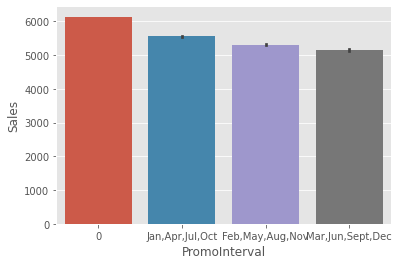

In [ ]:
sns.barplot(x= 'PromoInterval', y = 'Sales', data = df)

In [ ]:
# Fill the empty cells in CompetitionDistance column with the middle value of the values in CompetitionDistance
df['CompetitionDistance'].fillna(df['CompetitionDistance'].median(), inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1017209 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [ ]:
# checking types of data we have in each column
df.dtypes

Store                          int64
DayOfWeek                      int64
Date                          object
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

We have 'Date' column as object type, which we need to convert it in a 'Datatime data type' !!

In [ ]:
df['PromoInterval'].unique()
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,0
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,0
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,0
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,0
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,0


In [ ]:

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1017209 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

make from date column into three columns: day, month, year

In [ ]:
df['Date']= pd.to_datetime(df['Date'])
df.dtypes
# Create new columns
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Week'] = df['Date'].dt.week

df.head(10)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  import sys


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Day,Month,Year,Week
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,0,31,7,2015,31
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,0,30,7,2015,31
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,0,29,7,2015,31
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,0,28,7,2015,31
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,0,27,7,2015,31
5,1,7,2015-07-26,0,0,0,0,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,0,26,7,2015,30
6,1,6,2015-07-25,4364,500,1,0,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,0,25,7,2015,30
7,1,5,2015-07-24,3706,459,1,0,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,0,24,7,2015,30
8,1,4,2015-07-23,3769,503,1,0,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,0,23,7,2015,30
9,1,3,2015-07-22,3464,463,1,0,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,0,22,7,2015,30


In [ ]:
df.dtypes

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                         object
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                        object
Day                                   int64
Month                                 int64
Year                                  int64
Week                                  int64
dtype: object

# Data Exploration and Visualisation 

Which month the sales were high?

Text(0.5, 1.0, 'Average sales per month')

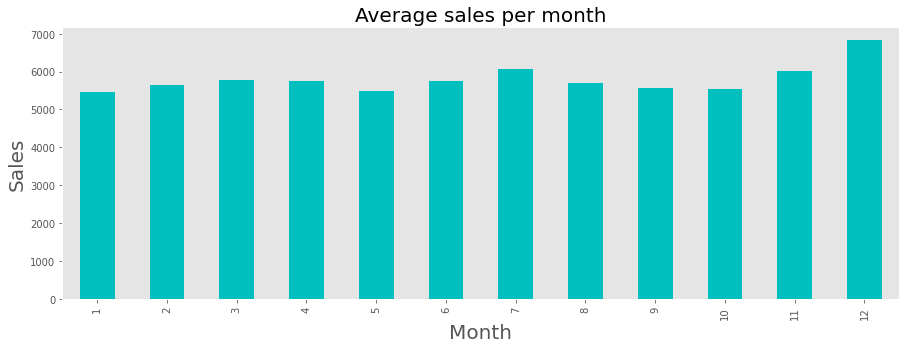

In [ ]:
best_month_sales = df.groupby(['Month'])[['Sales']].mean().round(2)
best_month_sales.plot.bar(figsize=(15 , 5), color = 'c', legend = 0)
plt.xlabel('Month' , size= 20)
plt.ylabel('Sales' , size= 20)
plt.grid()
plt.title('Average sales per month', size= 20)


In [ ]:
# Analysis: Which store type has the highest sales on average 
highest_sales_on_average_depending_on_the_store_type = df.groupby('StoreType')[['Sales']].mean().reset_index().round(2)
# highest_sales_on_average_depending_on_the_store_type = df.groupby('StoreType')[['Sales']].mean()
highest_sales_on_average_depending_on_the_store_type

# highest_sales_on_average_depending_on_the_store_type.reset_index()
# sns.barplot(x="DayOfWeek", y="Sales", data=df)
# sns.barplot(x='StoreType' , y= 'Sales', data = highest_sales_on_average_depending_on_the_store_type)
# highest_sales_on_average_depending_on_the_store_type.plot.bar(figsize=(15 , 5),legend = 0)
# plt.xlabel('StoreType' , size= 20)
# plt.ylabel('Sales' , size= 20)
# plt.grid()
# plt.title('The highest sales on average depending on the type store', size= 20)

,StoreType,Sales
0,a,5738.18
1,b,10058.84
2,c,5723.63
3,d,5641.82


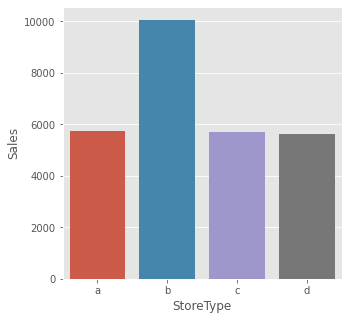

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
# sns.barplot(x="DayOfWeek", y="Sales", data=df)

sns.barplot(
    data=highest_sales_on_average_depending_on_the_store_type,
    x="StoreType", y="Sales"
)

In [ ]:
#Assortment
#StoreAssortments = df['Assortment'].value_counts().sort_values(ascending=False)
#pie_=StoreAssortments.plot.pie(autopct="%.1f%%",startangle=90, figsize=(30,30)
#pie_.set_title('Percentage of Stores by Assortment')

Text(0.5, 1.0, 'The highest sales on average depending on the Assortment type of the store')

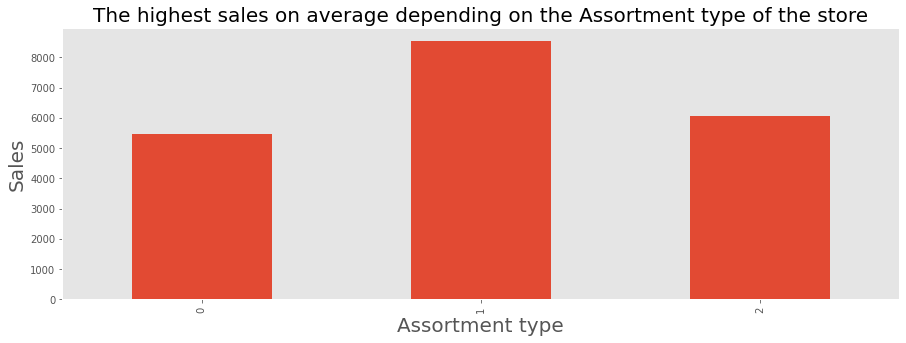

In [ ]:
# Analysis: Assortment and sales
highest_sales_on_average_depending_on_the_Assortment_type = df.groupby('Assortment')['Sales'].mean().reset_index().round(1)
highest_sales_on_average_depending_on_the_Assortment_type.plot.bar(figsize=(15 , 5), legend = 0)
plt.xlabel('Assortment type' , size= 20)
plt.ylabel('Sales' , size= 20)
plt.grid()
plt.title('The highest sales on average depending on the Assortment type of the store', size= 20)

In [ ]:
# Analysis: Average sales per customer in each store type
avarag_sales_avarage_customer_for_store_type = df.groupby('StoreType')['Sales','Customers'].mean().reset_index().round()
avarag_sales_avarage_customer_for_store_type
avarag_sales_avarage_customer_for_store_type['Avg_Sales_Customers_Store'] = ((avarag_sales_avarage_customer_for_store_type['Sales']/avarag_sales_avarage_customer_for_store_type['Customers']).round(2))
avarag_sales_avarage_customer_for_store_type.sort_values('Avg_Sales_Customers_Store' , ascending= False).sort_values('Sales', ascending = False)
avarag_sales_avarage_customer_for_store_type

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,StoreType,Sales,Customers,Avg_Sales_Customers_Store
0,a,5738.0,659.0,8.71
1,b,10059.0,1988.0,5.06
2,c,5724.0,673.0,8.51
3,d,5642.0,501.0,11.26


Text(0.5, 1.0, 'Number of each Rossman Store Type')

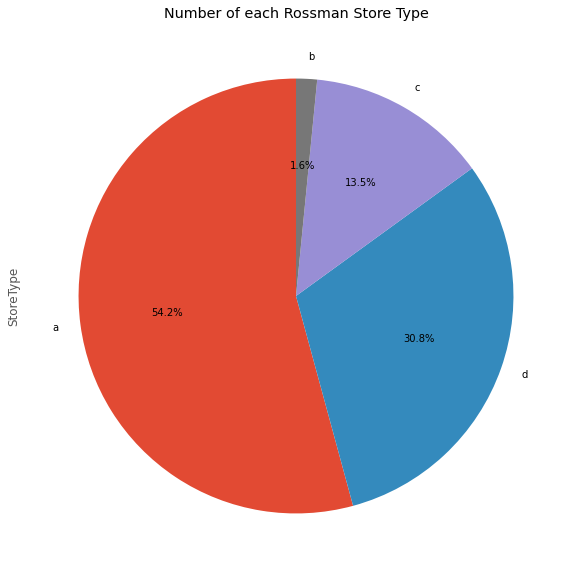

In [ ]:
# Storetypes numbers
rossmanStoreType = df['StoreType'].value_counts().sort_values(ascending=False)
#rossmanStoreType.plot.bar()
pie= rossmanStoreType.plot.pie(autopct="%.1f%%",startangle=90, figsize=(10,10))
pie.set_title('Number of each Rossman Store Type')

In [ ]:
# Code: Find the boundary of dates, i.e. the span across which we have the data.


df['Year'].unique()

array([2015, 2014, 2013])

In [ ]:
# Code: Is any store open on Sunday?


df.loc[(df['DayOfWeek']==7 ) & (df['Open'] == 1),'Store'].unique()

array([  85,  122,  209,  259,  262,  274,  299,  310,  335,  353,  423,
        433,  453,  494,  512,  524,  530,  562,  578,  676,  682,  732,
        733,  769,  863,  867,  877,  931,  948, 1045, 1081, 1097, 1099])

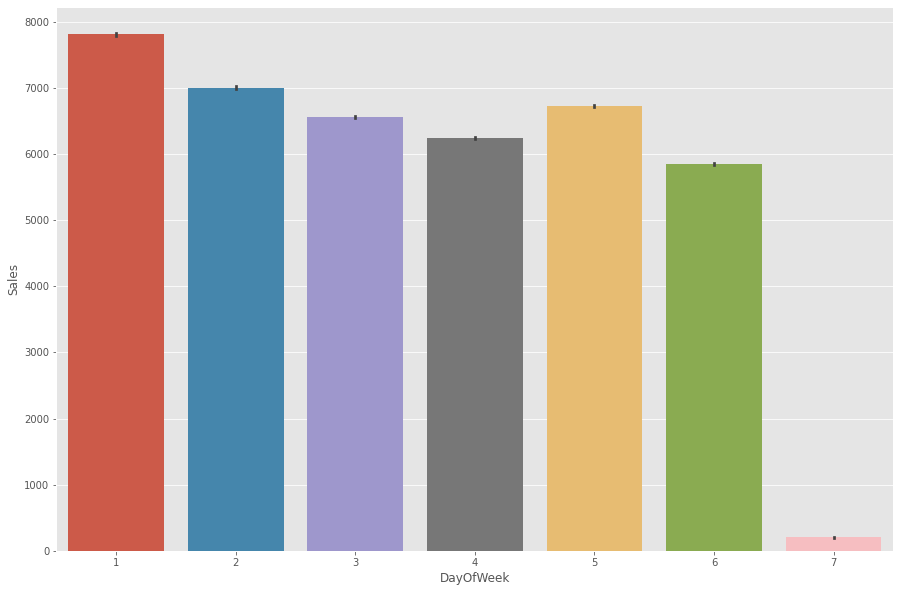

In [ ]:
# Weekdays and weekenddays vs Sales
fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(x="DayOfWeek", y="Sales", data=df)

In [ ]:
# Graph: sales vs promo > sales in 1 vs 0
df.groupby(['Promo'])[['Sales']].mean().round(2).sort_values('Sales', ascending = False)

,Sales
Promo,
1,7991.15
0,4406.05


Text(0.5, 1.0, 'Percentage of Stores, participated in Promo2')

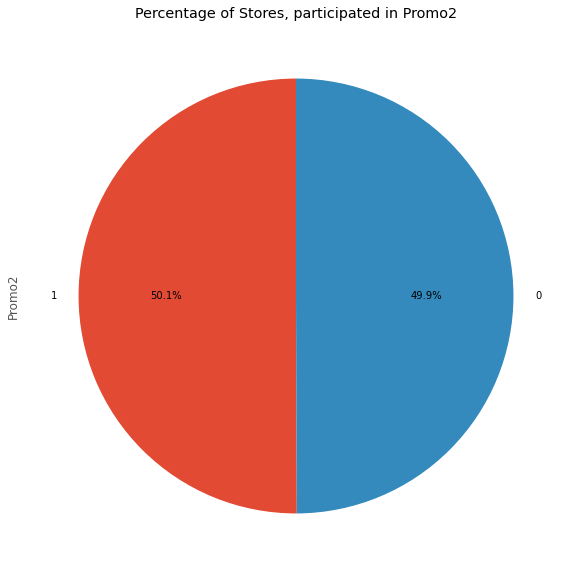

In [ ]:
# How many store participated in Promo2?
Promo2_ = df['Promo2'].value_counts().sort_values(ascending=False)
piee= Promo2_.plot.pie(autopct="%.1f%%",startangle=90, figsize=(10,10))
piee.set_title('Percentage of Stores, participated in Promo2')

In [ ]:
# sales vs holidays (school and state) 
df.groupby(['SchoolHoliday'])[['Sales']].mean().round(2)

,Sales
SchoolHoliday,
0,5620.98
1,6476.52


In [ ]:
# Holidays and number of customers. Do more people come during the holidays?

# StateHoliday vs Sales
# First combine  the 0 and '0':
df['StateHoliday']=df['StateHoliday'].map({'0':'Normal day', 'a':'Public Holiday', 'b':'Easter holiday', 'c':'Christmas', 0:'Normal day'})
df['StateHoliday'].unique()
# average_sales_on_state_holiday.plot.bar(figsize=(15 , 5), color = 'r', legend = 0)
# plt.xlabel('StateHoliday' , size= 20)
# plt.ylabel('Sales' , size= 20)
# plt.grid()
# plt.title('The average sales on atate holiday')


array(['Normal day', 'Public Holiday', 'Easter holiday', 'Christmas'],
      dtype=object)

In [ ]:
# then run the Sales:
shop_open = df[df['Open'] == 1]
shop_open.groupby(['StateHoliday'])[['Sales','Customers']].mean().reset_index().round(1).sort_values('Sales', ascending = False)

,StateHoliday,Sales,Customers
1,Easter holiday,9887.9,1686.9
0,Christmas,9743.7,1569.2
3,Public Holiday,8487.5,1279.2
2,Normal day,6953.5,762.1


In [ ]:
avg_customers_number_in_state_holiday = shop_open.groupby([('StateHoliday')])[['Customers']].mean().reset_index().round(1)
avg_customers_number_in_state_holiday
# .sort_values('Customers', ascending = False)
# avg_customers_number_in_state_holiday.plot.bar()
# avg_customers_number_in_state_holiday.plot.bar(figsize=(15 , 5), legend = 0)
# plt.xlabel('StateHoliday' , size= 20)
# plt.ylabel('Customers' , size= 20)
# plt.grid()
# plt.title('The average customers on state holiday')

,StateHoliday,Customers
0,Christmas,1569.2
1,Easter holiday,1686.9
2,Normal day,762.1
3,Public Holiday,1279.2


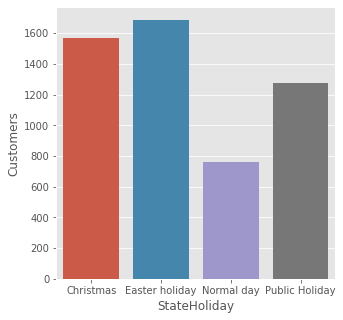

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
# sns.barplot(x="DayOfWeek", y="Sales", data=df)

sns.barplot(
    data=avg_customers_number_in_state_holiday,
    x="StateHoliday", y="Customers" 
)

Text(0.5, 1.0, 'The average sales per customer on state holiday')

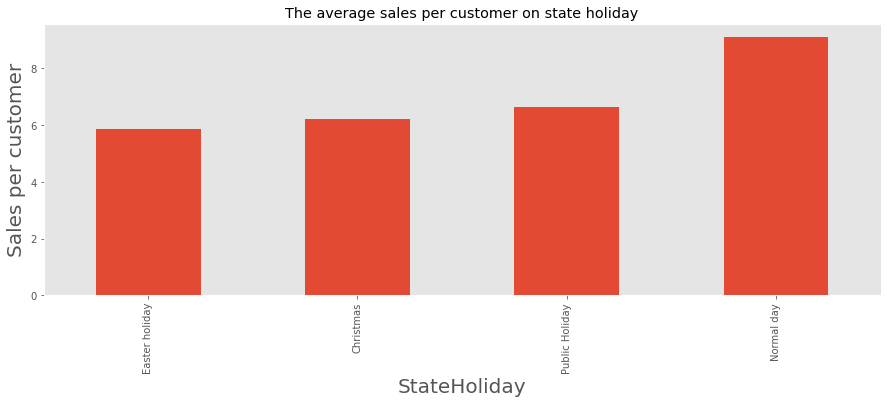

In [ ]:
# Find out how is
shop_open = df[df['Open'] == 1]
a = shop_open.groupby([('StateHoliday')])[['Sales','Customers']].mean().round(1).sort_values('Sales', ascending = False)
# a.head()
avg_spend_money_per_customer_in_state_holiday= ((a['Sales'])/(a['Customers'])).round(3)
avg_spend_money_per_customer_in_state_holiday.head()

avg_spend_money_per_customer_in_state_holiday.plot.bar(figsize=(15 , 5), legend = 0)
plt.xlabel('StateHoliday' , size= 20)
plt.ylabel('Sales per customer' , size= 20)
plt.grid()
plt.title('The average sales per customer on state holiday')

In [ ]:
#StateHoliday vs salse
#rossman_train['StateHoliday']=rossman_train['StateHoliday'].map({'0':'Normal day', 'a':'Public Holiday', 'b':'Easter holiday', 'c':'Christmas', 0:'Normal day'})
#shop_open = df[df['Open'] == 1]
#avarage_StateHoliday = shop_open.groupby([('StateHoliday')])[['Sales','Customers']].mean().reset_index().round(1).sort_values('Sales', ascending = False)
#avarage_StateHoliday['Sales per Customer']= (avarage_StateHoliday['Sales']/avarage_StateHoliday['Customers']).round(2)
#avarage_StateHoliday

In [ ]:
#Sales on weekdays vs sales on weekends. Make a new feature? If the sales on weekends are higher?

Daily_sales_for_whole_df_on_avg = shop_open.groupby(['DayOfWeek'])[['Sales']].mean().reset_index().round(2)

# Daily_sales_for_whole_df_on_avg.plot.bar(figsize=(15 , 5), legend = 0)
# plt.xlabel('Day of week' , size= 20)
# plt.ylabel('Sales on average' , size= 20)
# plt.grid()
# plt.title('The Daily sales in a week in average')

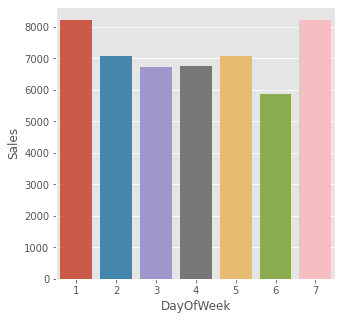

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
# sns.barplot(x="DayOfWeek", y="Sales", data=df)

sns.barplot(
    data=Daily_sales_for_whole_df_on_avg,
    x="DayOfWeek", y="Sales" 
)

In [ ]:
#Mon - Sun vs sales
#rossman_train.groupby([str('DayOfWeek')])[['Sales','Customers']].mean().reset_index().round(1).sort_values('Sales', ascending = False)

In [ ]:
# Weekly plot for the month of holidays: Christmas? and Easter?

# December weekly sales
holiday_sales = df[((df['StateHoliday']== 'Christmas') | (df['StateHoliday'] == 'Easter Holiday')) & (df['Open']== 1) ]
holiday_sales.groupby(['Week', 'Month'])[['Sales']].mean().sort_values('Month',ascending = True).round()
#df['StateHoliday'].unique()

#weekly_sales = df.groupby(['week', 'month'])[['Sales']].mean().sort_values('month',ascending = True).round()
#weekly_sales.tail()

# April weekly sales
#weekly_sales.head(21)

,,Sales
Week,Month,
52,12,9744.0


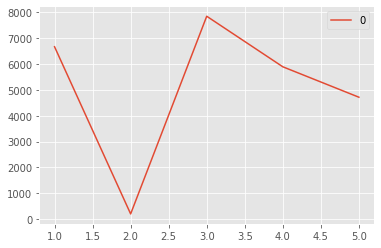

In [ ]:
weeks = [1,2,3,4,5]
April_weekly_sales = [5322, 5223, 5935, 4932, 9200]
December_weekly_sales = [6669, 197, 7850, 5893, 4715]

#AprilGraph = pd.DataFrame(April_weekly_sales, weeks)
#AprilGraph.plot(kind = 'line')
DecemberGraph = pd.DataFrame(December_weekly_sales, weeks)
DecemberGraph.plot(kind = 'line')

In [ ]:
#Promo2 interval and sales. Do store which don't take part in the sales sale less? Is promo of any use?
df['PromoInterval'].unique()
df.groupby(['Promo2','Year'])[['Sales']].mean().round(2).sort_values('Year', ascending = True).reset_index()
# import seaborn as sns       # plotting library

# sns.histplot(data=test, x="Promo2", bins=12, hue="Sales", multiple="dodge")
# g=sns.relplot(data=train_store, x="Customers", y="Sales", hue="DayOfWeek", s=20)
# g.set( xscale="log" , yscale="log")

,Promo2,Year,Sales
0,0,2013,6029.67
1,1,2013,5304.95
2,0,2014,6161.39
3,1,2014,5478.84
4,0,2015,6226.61
5,1,2015,5546.36


In [ ]:
#Graph/ Analysis: Promo2 interval and sales. Do store which don't take part in the sales sale less? Is promo of any use?
df['PromoInterval'].unique()
test = df.groupby(['Promo2','Year'])[['Sales']].mean().round(2).sort_values('Year', ascending = True).reset_index()
test
# test = df.groupby(['Year'])[['Sales']].mean().round(2).sort_values('Year', ascending = True).reset_index()


,Promo2,Year,Sales
0,0,2013,6029.67
1,1,2013,5304.95
2,0,2014,6161.39
3,1,2014,5478.84
4,0,2015,6226.61
5,1,2015,5546.36


In [ ]:
df.groupby(['PromoInterval', 'Year'])[['Sales']].mean().round(2).sort_values('Year', ascending = True).reset_index()


# PromoInterval_data

# PromoInterval_data.plot.bar(figsize=(15 , 5), color = 'y', legend = 0)
# plt.xlabel('PromoInterval' , size= 20)
# plt.ylabel('Sales' , size= 20)
# plt.grid()
# plt.title('The Daily sales in a week in average')

,PromoInterval,Year,Sales
0,0,2013,6029.67
1,"Feb,May,Aug,Nov",2013,5185.70
2,"Jan,Apr,Jul,Oct",2013,5443.83
3,"Mar,Jun,Sept,Dec",2013,5012.29
4,0,2014,6161.39
5,"Feb,May,Aug,Nov",2014,5398.72
6,"Jan,Apr,Jul,Oct",2014,5606.62
7,"Mar,Jun,Sept,Dec",2014,5223.65
8,0,2015,6226.61
9,"Feb,May,Aug,Nov",2015,5388.21


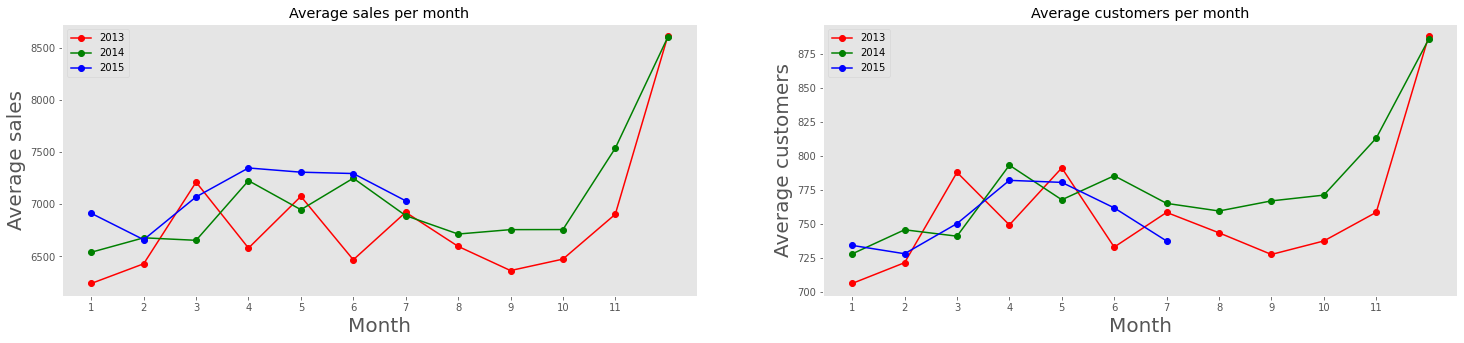

In [ ]:
#sales and Number of customers> line chart
df_year_2013 = df[(df['Year']== 2013) & (df['Open']== 1)]
df_year_2013_monthly = df_year_2013.groupby(['Month'])[['Sales' , 'Customers']].mean().reset_index()
df_year_2013_monthly

df_year_2014 = df[(df['Year']== 2014) & (df['Open']== 1)]
df_year_2014_monthly = df_year_2014.groupby(['Month'])[['Sales' , 'Customers']].mean().reset_index()
df_year_2014_monthly

df_year_2015 = df[(df['Year']== 2015) & (df['Open']== 1)]
df_year_2015_monthly = df_year_2015.groupby(['Month'])[['Sales' , 'Customers']].mean().reset_index()
df_year_2015_monthly

fig, ax= plt.subplots(nrows= 1, ncols=2 , figsize=(25,5))

ax[0].plot(df_year_2013_monthly['Month'],df_year_2013_monthly['Sales'], marker = 'o', color= 'r' , label= '2013')
ax[0].plot(df_year_2014_monthly['Month'],df_year_2014_monthly['Sales'], marker = 'o', color= 'g' , label= '2014')
ax[0].plot(df_year_2015_monthly['Month'],df_year_2015_monthly['Sales'], marker = 'o', color= 'b' , label= '2015')

ax[0].title.set_text('Average sales per month')
ax[0].set_xlabel('Month' , size = 20)
ax[0].set_ylabel('Average sales' , size = 20)

ax[0].grid()
ax[0].set_xticks(np.arange(1,12,step= 1))
ax[0].legend()

ax[1].plot(df_year_2013_monthly['Month'],df_year_2013_monthly['Customers'], marker = 'o', color= 'r' , label= '2013')
ax[1].plot(df_year_2014_monthly['Month'],df_year_2014_monthly['Customers'], marker = 'o', color= 'g' , label= '2014')
ax[1].plot(df_year_2015_monthly['Month'],df_year_2015_monthly['Customers'], marker = 'o', color= 'b' , label= '2015')

ax[1].title.set_text('Average customers per month')
ax[1].set_xlabel('Month' , size = 20)
ax[1].set_ylabel('Average customers' , size = 20)

ax[1].grid()
ax[1].set_xticks(np.arange(1,12,step= 1))
ax[1].legend()


In [ ]:
#sales vs competition distance > no relationship

# q=sns.regplot(data=full_data, x="CompetitionDistance", y="Sales",scatter_kws={"color": "grey"}, line_kws={"color": "purple"})

# # set title
# plt.title("Competition Distance vs Sales")

# # hide frame
# for position in q.spines.keys():
#   q.spines[position].set_visible(False)

# plt.show()


Text(0.5, 1.0, 'Influence on the store number 6 - sales after the opening of a competition nearby on 12.2013')

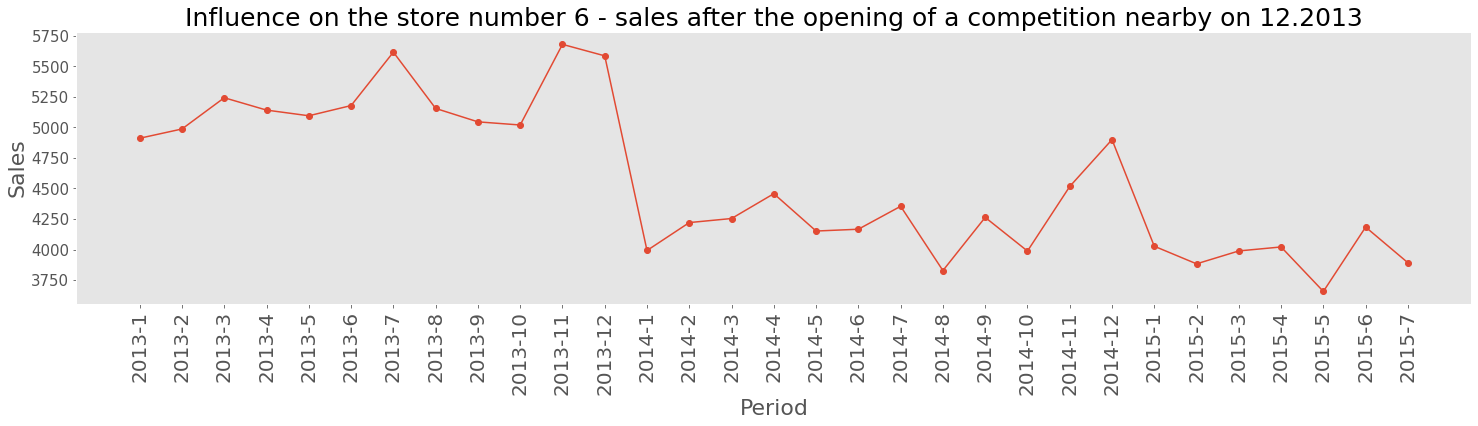

In [ ]:
# Check the competition effect on the sales of store (x), when it is nearby opened ?
# Example : Store number 6 
# Competition had on 12.2013 opened

df.loc[(df['Store']==6 ) & (df['Open'] == 1),'Store']

Store_6 = df[df['Store'] == 6]
Store_6 = Store_6.groupby(['Year', 'Month'])['Sales'].mean().reset_index()

plt.figure(figsize=(25,5))
plt.plot(np.arange(1,Store_6 .shape[0]+1), Store_6['Sales'], marker = 'o')
plt.xlabel('Period',size =22)
plt.ylabel('Sales',size =22)

years= ['2013','2014','2015']
xticks_array= []
for y in years:
    for m in range (1,13):
	    string = y+  '-' +str(m)
	    xticks_array.append(string)
     
plt.xticks(np.arange(1, Store_6.shape[0]+1),xticks_array, rotation= 90, size = 20)
plt.yticks(size=15)
plt.grid()
plt.title('Influence on the store number 6 - sales after the opening of a competition nearby on 12.2013', size = 25)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 22 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  object        
 10  Assortment                 1017209 non-null  object        
 11  CompetitionDistance        1017209 no

In [ ]:
# Replace NAN with 0 

df["CompetitionOpenSinceMonth"] = df["CompetitionOpenSinceMonth"].fillna(0)
df["CompetitionOpenSinceYear"] = df["CompetitionOpenSinceYear"].fillna(0)

df["Promo2SinceWeek"] = df["Promo2SinceWeek"].fillna(0)
df["Promo2SinceYear"] = df["Promo2SinceYear"].fillna(0)

df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Day,Month,Year,Week
0,1,5,2015-07-31,5263,555,1,1,Normal day,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,31,7,2015,31
1,1,4,2015-07-30,5020,546,1,1,Normal day,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,30,7,2015,31
2,1,3,2015-07-29,4782,523,1,1,Normal day,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,29,7,2015,31
3,1,2,2015-07-28,5011,560,1,1,Normal day,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,28,7,2015,31
4,1,1,2015-07-27,6102,612,1,1,Normal day,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,27,7,2015,31


In [ ]:
df = pd.get_dummies(data = df, columns= ['StoreType', 'Assortment', 'PromoInterval', 'StateHoliday'])
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Day,Month,Year,Week,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",StateHoliday_Christmas,StateHoliday_Easter holiday,StateHoliday_Normal day,StateHoliday_Public Holiday
0,1,5,2015-07-31,5263,555,1,1,1,1270.0,9.0,2008.0,0,0.0,0.0,31,7,2015,31,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0
1,1,4,2015-07-30,5020,546,1,1,1,1270.0,9.0,2008.0,0,0.0,0.0,30,7,2015,31,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0
2,1,3,2015-07-29,4782,523,1,1,1,1270.0,9.0,2008.0,0,0.0,0.0,29,7,2015,31,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0
3,1,2,2015-07-28,5011,560,1,1,1,1270.0,9.0,2008.0,0,0.0,0.0,28,7,2015,31,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0
4,1,1,2015-07-27,6102,612,1,1,1,1270.0,9.0,2008.0,0,0.0,0.0,27,7,2015,31,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 33 columns):
 #   Column                          Non-Null Count    Dtype         
---  ------                          --------------    -----         
 0   Store                           1017209 non-null  int64         
 1   DayOfWeek                       1017209 non-null  int64         
 2   Date                            1017209 non-null  datetime64[ns]
 3   Sales                           1017209 non-null  int64         
 4   Customers                       1017209 non-null  int64         
 5   Open                            1017209 non-null  int64         
 6   Promo                           1017209 non-null  int64         
 7   SchoolHoliday                   1017209 non-null  int64         
 8   CompetitionDistance             1017209 non-null  float64       
 9   CompetitionOpenSinceMonth       1017209 non-null  float64       
 10  CompetitionOpenSinceYear        1017209 no

# **Machine learning** 

In [ ]:
df.drop('Date', axis= 1, inplace = True)

In [ ]:
train_x = df.drop(['Sales','Customers'], axis=1)
train_y = df['Sales']
train_x.info()
train_y

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 30 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   Store                           1017209 non-null  int64  
 1   DayOfWeek                       1017209 non-null  int64  
 2   Open                            1017209 non-null  int64  
 3   Promo                           1017209 non-null  int64  
 4   SchoolHoliday                   1017209 non-null  int64  
 5   CompetitionDistance             1017209 non-null  float64
 6   CompetitionOpenSinceMonth       1017209 non-null  float64
 7   CompetitionOpenSinceYear        1017209 non-null  float64
 8   Promo2                          1017209 non-null  int64  
 9   Promo2SinceWeek                 1017209 non-null  float64
 10  Promo2SinceYear                 1017209 non-null  float64
 11  Day                             1017209 non-null  int64  
 12  

0          5263
1          5020
2          4782
3          5011
4          6102
           ... 
1017204    4771
1017205    4540
1017206    4297
1017207    3697
1017208       0
Name: Sales, Length: 1017209, dtype: int64

In [ ]:
# Splitting the data into train and test set (80% train and 20% test)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

In [ ]:
# Import random forest regressor model
from sklearn.ensemble import RandomForestRegressor

# # instantiate random forest regressor with (RandomForestRegressor)
#     # n_estimatorsint, default=100 , (>100 -> crash)
#     # random_state=42 : get the same result , every time when we run the code
rfr=RandomForestRegressor(n_jobs=-1,verbose=10,random_state=42)

# # Fit the data 
rfr.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   12.4s


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   25.1s


building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.0min


building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100


[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.4min


building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  2.2min


building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.8min


building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.7min


building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.6min


building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  5.7min


building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  6.7min


building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  8.1min


building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  9.3min


building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.9min finished


RandomForestRegressor(n_jobs=-1, random_state=42, verbose=10)

In [ ]:

# Get Importance of the features
feature_importances_ = pd.DataFrame(rfr.feature_importances_,index=X_train.columns)
feature_importances_= feature_importances_.sort_values(by=0,ascending=False)
feature_importances_

,0
Open,0.459925
CompetitionDistance,0.101555
Store,0.087030
Promo,0.073256
CompetitionOpenSinceYear,0.039952
DayOfWeek,0.037315
CompetitionOpenSinceMonth,0.036437
Day,0.024821
Week,0.022031
Promo2SinceYear,0.021389


In [ ]:
feature_importances_.head()

,0
Open,0.459925
CompetitionDistance,0.101555
Store,0.087030
Promo,0.073256
CompetitionOpenSinceYear,0.039952


Text(0.5, 1.0, 'Importance of the features in random forest regressor ')

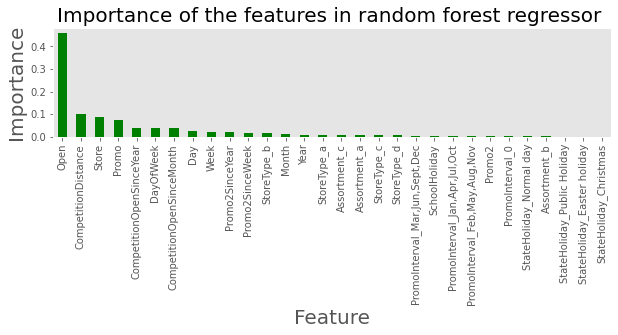

In [ ]:
# Represent features in graph
feature_importances_.plot.bar(figsize=(10 , 2), color = 'g', legend = 0)
plt.xlabel('Feature' , size= 20)
plt.ylabel('Importance' , size= 20)
plt.grid()
plt.title('Importance of the features in random forest regressor ', size= 20)

In [ ]:
# Get prediction using our test data
predict=rfr.predict(X_test)
predict

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    1.3s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    1.8s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    3.4s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    4.8s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    6.0s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    7.3s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:    8.5s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:   10.0s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   11.6s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   12.3s finished


array([11330.81,  1976.35,  4610.23, ...,  6130.52,  7656.83,  9684.14])

In [ ]:
# Import regression metrics and sqrt
from sklearn.metrics import mean_squared_error
from math import sqrt

# # calculating the performance of random forest model
mse=mean_squared_error(y_test, predict)
print('Root Mean Square Error {}'.format(sqrt(mse)))

Root Mean Square Error 828.7567389028258



is it good ?

In [ ]:
from sklearn.linear_model import LinearRegression


In [ ]:
lr=LinearRegression(n_jobs=-1)
lr.fit(X_train, y_train)

LinearRegression(n_jobs=-1)

In [ ]:
lr_predict = lr.predict(X_test)

In [ ]:

mse=mean_squared_error(y_test, lr_predict)
print('Root Mean Square Error {}'.format(sqrt(mse)))

Root Mean Square Error 2508.917338730856
